### Figure 1 notebook for image analysis steps

In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import patches as mpatches
import numpy as np
import tifffile
from skimage.measure import block_reduce
import rasterio
import cv2
import geopandas as gpd
from shapely.geometry import shape, box
from shapely.affinity import translate
import string


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style
# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

plt.ion()

# Helper functions
def load_image_roi(file_name, window_coords):
    try:
        with rasterio.open(file_name) as aws_file:
            roi = aws_file.read(1, window=rasterio.windows.Window(*window_coords))
    except OSError:
        print(f"File read error on {file_name}")
        roi = np.zeros([window_coords[3],window_coords[2]])
        
    return np.squeeze(roi)

def convert_eight_bit(img):
    # Normalize contrast before reducing bit depth
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    norm_img = clahe.apply(img)    
    bg_subtract = norm_img - norm_img.min()
    
    if bg_subtract.max() == 0:
        return np.zeros(img.shape, dtype=np.uint8)
    else:
        range_norm = bg_subtract / bg_subtract.max()      
        return np.array(range_norm * 255, dtype=np.uint8)
    
def increase_brightness(img, multiplier=1, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = (255 - value) / multiplier
    v[v > lim] = 255
    v[v <= lim] = (v[v <= lim] * multiplier) + value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [2]:
# Experiment Info
experiment = 'MsKidney_CellBoundary_VZG116_111921'
region = 0

# Image input info
image_base_path = "../../../data/MosaicImages"
nuclear_stain = "DAPI"
cytoplasmic_stain = "Cellbound3"
FISH_bit = "bit20"
z_level = 3

# Geometry input info
geom_base_path = "../../../data/RawData"

# Formatted input paths using merfish_analysis folder structure, change to fit your data paths
nuclear_file_name = f"{image_base_path}/{experiment}/mosaic_{nuclear_stain}_z{z_level}.tif"
cyto_file_name = f"{image_base_path}/{experiment}/mosaic_{cytoplasmic_stain}_z{z_level}.tif"
FISH_file_name = f"{image_base_path}/{experiment}/mosaic_{FISH_bit}_z{z_level}.tif"
geometry_file_name = f"{geom_base_path}/{experiment}/cell_boundaries.geojson"
transcripts_file_name = f"{geom_base_path}/{experiment}/barcodes.csv"
transformation_matrix_file_name = f"{geom_base_path}/{experiment}/micron_to_mosaic_pixel_transform.csv"

In [3]:
# Load data

# Transformation matrix
transformation_matrix = np.loadtxt(transformation_matrix_file_name)

# Calculate the scalebar
size_of_one_pixel = 1 / transformation_matrix[0,0]

print('Transformation matrix loaded.')

# Segmentation boundaries
boundaries = gpd.read_file(geometry_file_name)
geometries = boundaries['geometry']
all_cells = [shape(x) for x in geometries]

print('Segmentation boundaries loaded.')

# Transcripts
transcripts = pd.read_csv(transcripts_file_name)

print('Transcripts loaded.')

# DAPI mosaic
dapi_mosaic = tifffile.TiffFile(nuclear_file_name).asarray()

print('DAPI mosaic loaded.')

# Cellbound3 mosaic
cellbound3_mosaic = tifffile.TiffFile(cyto_file_name).asarray()

print('Cellbound3 mosaic loaded.')

Transformation matrix loaded.
Segmentation boundaries loaded.
Transcripts loaded.
DAPI mosaic loaded.
Cellbound3 mosaic loaded.


### Panel A: Original mosaic for the whole dataset

In [4]:
# Downsample DAPI and cellbound3 mosaics using block reduce for low-res plot
dscale = 20

dapi_mosaic_lowres = block_reduce(dapi_mosaic, block_size=(dscale, dscale), func=np.mean)

cellbound3_mosaic_lowres = block_reduce(dapi_mosaic, block_size=(dscale, dscale), func=np.mean)

# Convert to eight-bit
blue = convert_eight_bit(dapi_mosaic_lowres.astype('uint16'))
green = convert_eight_bit(cellbound3_mosaic_lowres.astype('uint16'))

print('DAPI and Cellbound3 mosaics downsampled and converted to eight-bit.')

DAPI and Cellbound3 mosaics downsampled and converted to eight-bit.


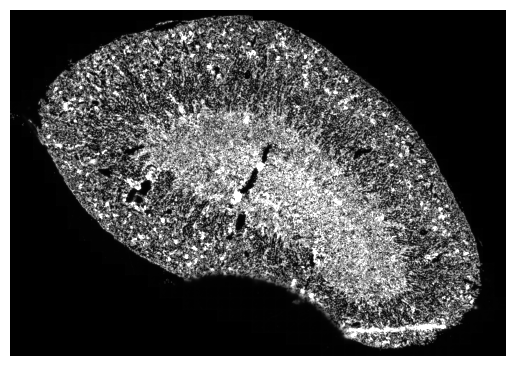

In [5]:
plt.axis('off')
plt.imshow(dapi_mosaic_lowres, cmap='gray', vmax=20000, origin='lower')
plt.show()

### Panel B: Zoomed in raw image with example channels and decoded transcripts/segmentation boundaries

In [6]:
# Viewport location. Formatted as: [column_offset (x), row_offset (y), width, height], units are pixels
xMin = 12000
yMin = 40000
width = 1000
height = 1000
xMax = xMin + width
yMax = yMin + height
viewport = [xMin, yMin, width, height] 

# Read image data from viewport
blue = convert_eight_bit(load_image_roi(nuclear_file_name, viewport))
green = convert_eight_bit(load_image_roi(cyto_file_name, viewport))
red = convert_eight_bit(load_image_roi(FISH_file_name, viewport))

# Filter geometry data to match viewport
viewport_poly = box(viewport[0], viewport[1], viewport[0] + viewport[2], viewport[1] + viewport[3])
viewport_cells = (cell for cell in all_cells if viewport_poly.intersects(cell))
aligned_cells = [translate(cell, xoff=0-viewport[0], yoff=0-viewport[1]) for cell in viewport_cells]

# Filter transcripts
viewport_tx = transcripts[(transcripts['global_x_mosaic'] > xMin) &
                         (transcripts['global_x_mosaic'] < xMax) &
                         (transcripts['global_y_mosaic'] > yMin) &
                         (transcripts['global_y_mosaic'] < yMax)]
print('Viewport created.')

/data01/jonathan.liu/miniconda3/envs/geo_env/lib/python3.10/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Viewport created.


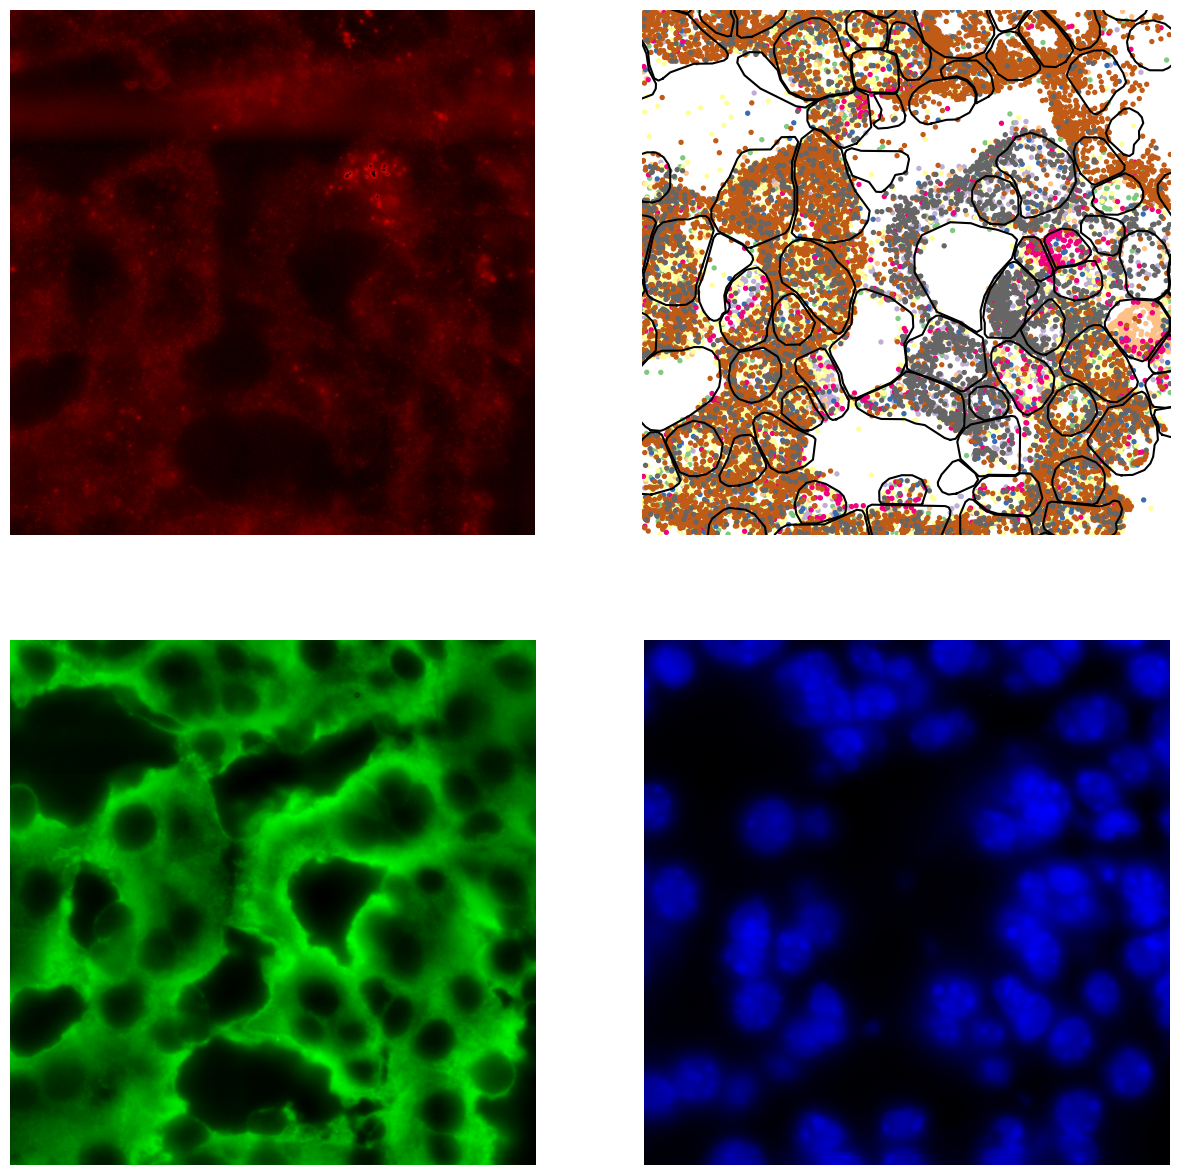

In [7]:
# Plot panels
fig, ax = plt.subplots(2,2, figsize=(15,15))
zero_im = np.zeros(blue.shape, dtype=np.uint8)

# Sample MERFISH bit
im = cv2.merge((red*3, zero_im, zero_im))
ax[0,0].imshow(im, origin='lower')
ax[0,0].axis("off")

# Positions of decoded transcripts + segmented boundaries
for cell in aligned_cells:
    ax[0,1].plot(*cell.exterior.xy, "k")
ax[0,1].scatter(viewport_tx['global_x_mosaic'] - xMin,
                viewport_tx['global_y_mosaic'] - yMin,
                c=viewport_tx['barcode_id'],
                cmap='Accent',
                s=8)
ax[0,1].axis('off')
ax[0,1].set_xlim(0, width)
ax[0,1].set_ylim(0, height)

# CellBound3
im = cv2.merge((zero_im, green, zero_im))
ax[1,0].imshow(im, origin='lower')
ax[1,0].axis("off")


# DAPI
im = cv2.merge((zero_im, zero_im, blue))
ax[1,1].imshow(im, origin='lower')
ax[1,1].axis("off")


plt.show()

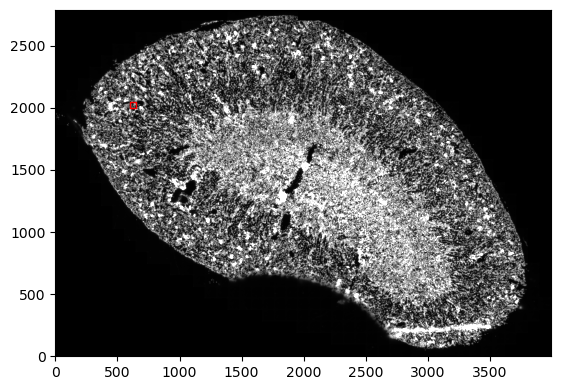

In [8]:
# Plot the mosaic image and show the window view
globMinX, globMinY = (xMin/dscale, yMin/dscale)
globMaxX, globMaxY = (xMax/dscale, yMax/dscale)

# Create rectangle for zoomed in snippet
rect = mpatches.Rectangle((globMinX, globMinY), globMaxX - globMinX, 
                          globMaxY - globMinY, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()
ax.imshow(dapi_mosaic_lowres, cmap='gray', vmax=20000, origin='lower')
ax.add_patch(rect)
plt.show()

### Plot combined figure

22009 transcripts in Panel E.


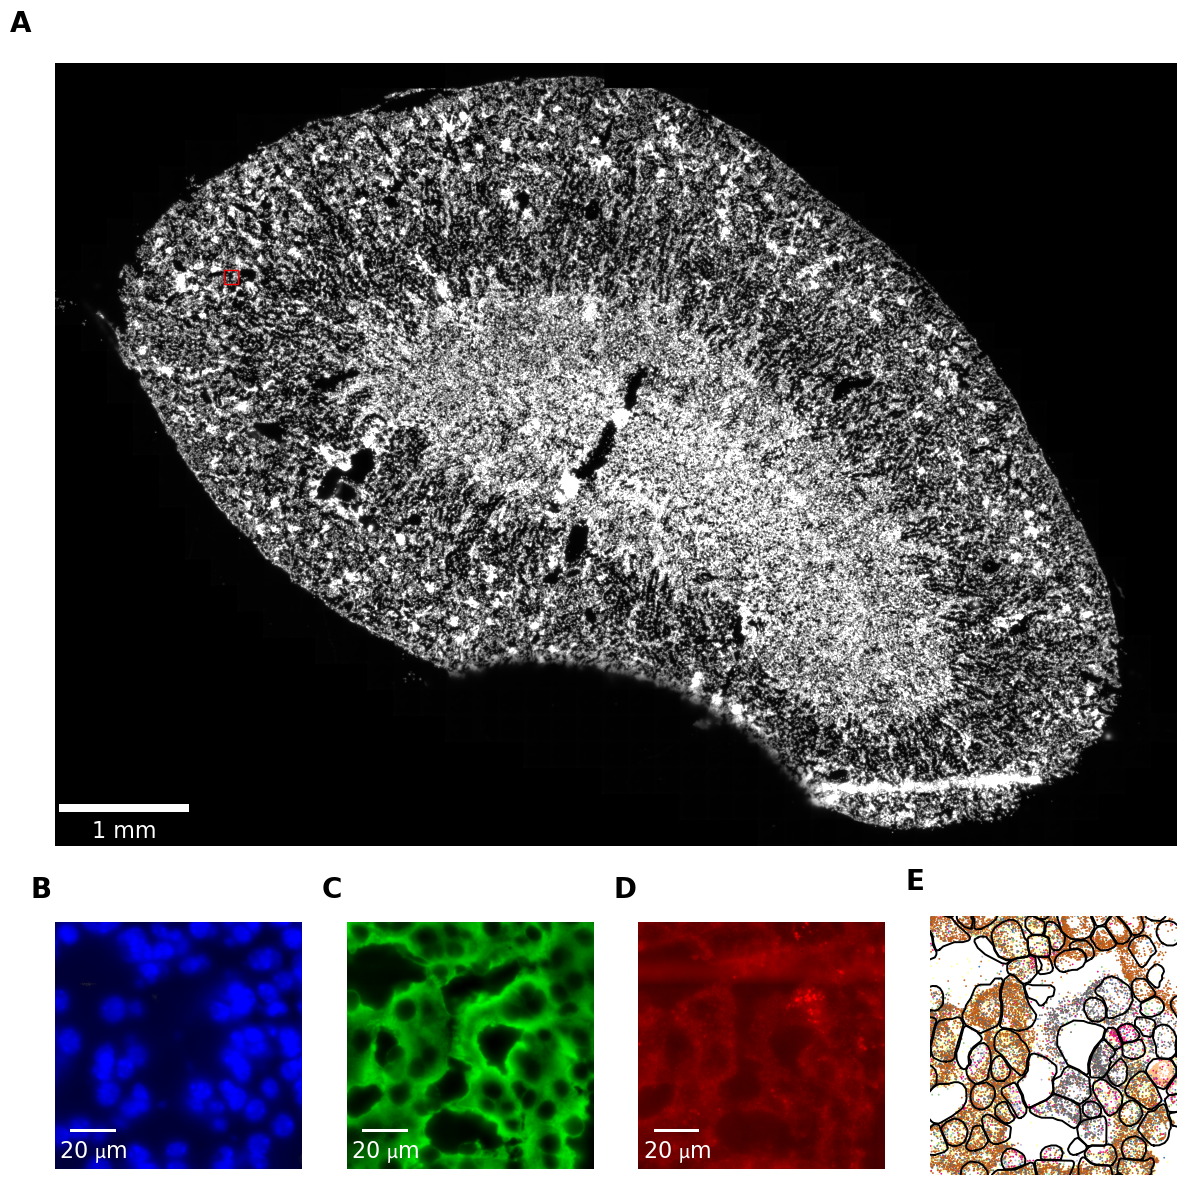

In [9]:
# Plot the whole figure
set_plotting_style()
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
gs = ax[0,0].get_gridspec() #Get gridspecs

# remove the underlying axes for Panel A
for i in [0,1,2]:
    for j in [0,1,2,3]:
        ax[i,j].remove()

axbig = fig.add_subplot(gs[0:3, 0:4])

# Panel A: low-res mosaic
axbig.axis("off")
axbig.imshow(dapi_mosaic_lowres, cmap="gray", vmax=20000, aspect='equal', origin='lower')
scalebar = ScaleBar(size_of_one_pixel*dscale/1000, "mm", color='w', box_color='k', box_alpha=0, location='lower left', 
                   font_properties={'size':16})
axbig.add_artist(scalebar)
rect = mpatches.Rectangle((globMinX, globMinY), globMaxX - globMinX, 
                          globMaxY - globMinY, linewidth=1, edgecolor='r', facecolor='none')
axbig.add_patch(rect)

# Panel B: DAPI
axis = ax[3,0]
axis.axis("off")
im = increase_brightness(cv2.merge((zero_im, zero_im, blue)), 1, 50)
axis.imshow(im, origin='lower')
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0, location='lower left', 
                   font_properties={'size':16})
axis.add_artist(scalebar)

# Panel C: cell boundary stain
axis = ax[3,1]
axis.axis("off")
im = cv2.merge((zero_im, green, zero_im))
axis.imshow(im, origin='lower')
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0, location='lower left', 
                   font_properties={'size':16})
axis.add_artist(scalebar)


# Panel D: Bit 1
axis = ax[3,2]
axis.axis("off")
im = increase_brightness(cv2.merge((red, zero_im, zero_im)), 3, 50)
axis.imshow(im, origin='lower')
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0, location='lower left', 
                   font_properties={'size':16})
axis.add_artist(scalebar)

                  
# Panel E: decoded transcripts + segmented boundaries
# Leave this blank since we will replace with a png
axis = ax[3,3]
axis.axis("off")
for cell in aligned_cells:
    axis.plot(*cell.exterior.xy, "k")
axis.scatter(viewport_tx['global_x_mosaic'] - xMin,
                viewport_tx['global_y_mosaic'] - yMin,
                c=viewport_tx['barcode_id'],
                cmap='Accent',
                s=1,
                rasterized=True)
    
axis.set_xlim(0, width)
axis.set_ylim(0, height)
scalebar = ScaleBar(size_of_one_pixel, "um", color='k', box_color='k', box_alpha=0, location='lower left', 
                   font_properties={'size':16})

# How many transcripts are shown in Panel E?
N_transcripts = len(viewport_tx)
print(str(N_transcripts) + ' transcripts in Panel E.')


# Label subpanels
axes = [axbig, ax[3,0], ax[3,1], ax[3,2], ax[3,3]]
for n, ax in enumerate(axes):
    if n == 0:
        ax.text(-0.04, 1.04, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    else:
        ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
fig.tight_layout()

plt.show()

In [14]:
# Export figures
fig.savefig('../../figures/Fig1_image_analysis_example.svg', transparent=True)
fig.savefig('../../figures/Fig1_image_analysis_example.png', transparent=True)

#subfig.savefig('../../figures/Fig1_image_analysis_example_PanelE.png', transparent=True)

print('Figures saved.')

Figures saved.
